# RUC Practical AI Final Project: (Your Title)

# Imports

In [1]:
# Libraries imports
import numpy as np

# modules imports
from finalproject.data_loader import load_lfw_data

# Data loader
ipsum lorem

In [2]:
# Load the dataset
loader = load_lfw_data()

# Access the data
print("Dataset shapes:")
print(f"Images: {loader.images.shape}")
print(f"Data: {loader.data.shape}")
print(f"Target: {loader.target.shape}")
print(f"\nTarget names: {[str(name) for name in loader.target_names]}")

# Get class distribution
distribution = loader.get_class_distribution()
print("\nClass distribution:")
for name, count in distribution.items():
    print(f"  {name}: {count} images")


Dataset will be saved to: ../dataset/
✓ Dataset directory already exists
  Location: d:\Rutgers\PAI\final_project_PAI\final-project-Malav786\dataset\lfw_home
Dataset shapes:
Images: (1288, 50, 37)
Data: (1288, 1850)
Target: (1288,)

Target names: ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']

Class distribution:
  Ariel Sharon: 77 images
  Colin Powell: 236 images
  Donald Rumsfeld: 121 images
  George W Bush: 530 images
  Gerhard Schroeder: 109 images
  Hugo Chavez: 71 images
  Tony Blair: 144 images


# EDA

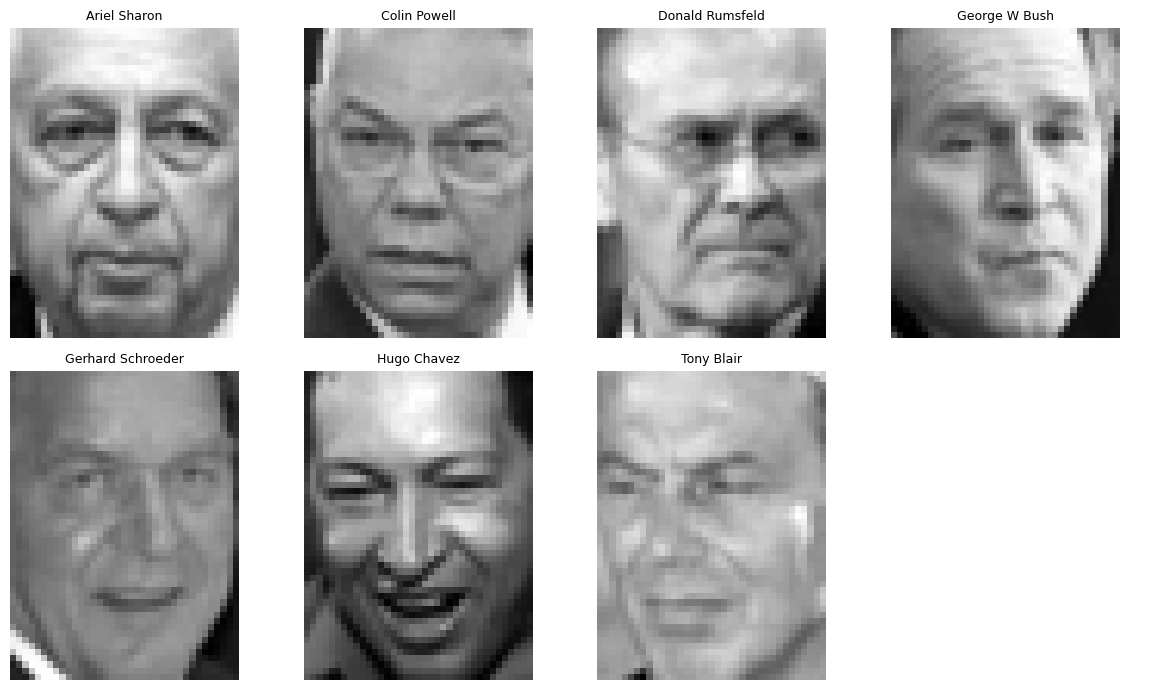

In [3]:
loader.show_distinct_people(n_cols=4, seed=42)